# Application of the ensemble Kalman filter (EnKF) to Lorenz's 1963 model

$$
\newcommand{\myd}{\mathrm{d}}
\newcommand{\statev}{\mathbf{X}}
\newcommand{\lrayleigh}{{\mathrm{r}}}
\newcommand{\rayleigh}{{\mathrm{Ra}}}
\newcommand{\pr}{\mathrm{Pr}}
\newcommand{\adj}{T}
\newcommand{\tstep}{\Delta t}
$$

The goal now is to get familiar with the working of a sequential assimilation scheme, running a so called twin experiment: A true, reference model trajectory $\statev_i^t$ is generated ($t$ stands for true, $i$ for the discrete time index). The reference trajectory is used to construct a catalog of synthetic observations. These observations are then assimilated in order to correct a second model trajectory, which differs from the first one (the true one). In our case it will differ because we will assume a different initial condition, $\statev_0 \neq \statev_0^t$.

Twin experiments (also called OSSE, Observing System Assimilation Experiments) are a logical first step when implementing an assimilation scheme, since they allow to develop an understanding for the behaviour of the scheme, without the additional complexity which may arise from the inability of the forward model to represent some of the physics expressed in the observations.

Today we will run these twin experiments using Lorenz's 1963 model, and we will resort to the ensemble Kalman filter, which is a standard sequential assimilation scheme. 

In [1]:
# Uncomment this line to make it interactive in JupyterLab!
# %matplotlib widget

from math import ceil
import torch
import matplotlib.pyplot as plt
from forwardModel import forwardModel_r
from deepda import apply_KF, apply_EnKF

#### Fix random seed for reproducibility

In [2]:
import random
import numpy

random.seed(0)
numpy.random.seed(0)
torch.manual_seed(0)
device = "cpu"

## Definition of the reference trajectory

In [3]:
# We define the control parameters here
rayleigh = 35
prandtl = 10.
b = 8./3.
# rayleigh = 0.
# prandtl = 0.
# b = 0.
# initial condition for the true reference trajectory
x0 = torch.tensor([0., 1., 2.], device=device)

# integration time parameter
dt = 1.e-3      # This is time step size
T = 25.         # Total integration time, can be as short as 10 to speed things up
n_steps = ceil(T / dt)
time = torch.linspace(0., T, n_steps + 1, device=device)  # array of discrete times

# numerical integration given initial conditions and control parameters
xt = forwardModel_r(x0, time, rayleigh, prandtl, b)

## Creation of the catalog of synthetic observations 

This is where we specify which variables are observed (we can decide that 1, 2 or even all 3 of them are measured), how often, and how accurate these observations are. To this end, we add an observation noise to the true value of the field of interest. This noise is assumed to be Gaussian, with standard deviation $\sigma_{obs}$. 

In [4]:
# Which variables do we observe?
WhichVariablesAreObserved = torch.tensor([1, 1, 1])
#  Determines which variables are available to
#  the EnKF. For example:
#  WhichVariablesAreObserved = [1 1 1];
#  means: X, Y, Z are observed
#  WhichVariablesAreObserved = [1 0 1];
#  means: X and Z are observed
#  WhichVariablesAreObserved = [1 0 0];
# means: X is observed
sigobs = 2.  # standard deviation of the observation noise
# We generate the synthetic data
#  Construct observation matrix H
#  ........................................................................
# H = torch.diag(WhichVariablesAreObserved)
y_size = int(WhichVariablesAreObserved.sum())

# H = torch.zeros((y_size, 3), device=device)
# iy = 0
# for ix in range(3):
#     if WhichVariablesAreObserved[ix] > 0:
#         H[iy, ix] = 1.
#         iy += 1

In [5]:
# def H(x: torch.Tensor):
#     y = torch.empty_like(x)
#     y[0, ...] = x[0, ...] * x[1, ...]
#     y[1, ...] = x[1, ...] + x[2, ...]
#     y[2, ...] = x[0, ...] * x[2, ...] + x[1, ...]
#     return y
def H(x: torch.Tensor):
    h = torch.zeros((y_size, 3))
    iy = 0
    for ix in range(3):
        if WhichVariablesAreObserved[ix] > 0:
            h[iy, ix] = 1.
            iy += 1
    return h @ x

In [6]:
# How often do we observe the true state?
dtobs = 0.5  # time between observations
nobs = ceil(T / dtobs)  # number of times observations are performed
# no observation at t=0
gap = int(dtobs / dt)  # number of time steps between each observation
time_obs = time[gap::gap]
# Generate vector of observations
y = torch.zeros((y_size, nobs), device=device)
R = torch.diag(torch.tile(torch.tensor(sigobs**2, device=device), (y_size,)))
sqrt_s = torch.sqrt(R)
# y = Hxt
y = H @ xt[:, gap::gap] if isinstance(H, torch.Tensor) else H(xt[:, gap::gap])
# compute observation error
noise = sqrt_s @ torch.randn(size=y.shape, device=device)
# y = Hxt + epsilon
y = y + noise

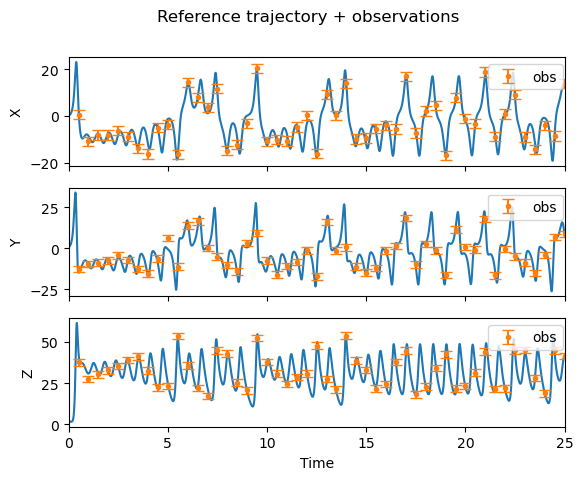

In [7]:
# Plot reference trajectory and the observations that will be fed to the EnKF
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)
iobs = 0
for k, comp in enumerate(["X", "Y", "Z"]):
    ax[k].plot(time.cpu(), xt.cpu()[k, :])
    if WhichVariablesAreObserved[k] > 0:
        ax[k].errorbar(time_obs.cpu(), y.cpu()[iobs, :], yerr=sqrt_s.cpu()[iobs, iobs],
                       fmt='o', markersize=3, capsize=4, label='obs')
        ax[k].legend(bbox_to_anchor=(1.01, 1), loc='upper right', frameon=True)
        iobs += 1
    ax[k].set_ylabel(comp)
ax[-1].set_xlabel('Time')
ax[-1].set_xlim(time.cpu()[0], time.cpu()[-1])
fig.suptitle('Reference trajectory + observations')
plt.show()

## Application of the Ensemble Kalman Filter

We will now assimilate these observations into a model whose trajectory will be hopefully drawn towards the true one, trough the sequential assimilation of data. 

The ensemble, which is assumed to be centered on a zero initial condition, is characterized by 

+ its size ($N_e$ is the number of elements of the ensemble), 
+ its initial spread that is also assumed to follow Gaussian statistics, with a standard deviation denoted by $\sigma_{ens}$


In [8]:
# Initialization of the Ensemble
Ne = 50  # Number of ensemble members
# The ensemble is centered on a zero initial condition
x0ens = torch.tensor([0., 0., 0.], device=device)
sigens = 10  # standard deviation of the ensemble
# initial covariance matrix
P0 = (sigens**2)*torch.eye(3, device=device)

We have all the ingredients we need (physical model, observations, their statistics, initial ensemble) to apply the EnKF. 
The python script `myEnKF.py` contains the implementation of the EnKF. It returns two numpy arrays:
+ `xEnKF`, which is the trajectory of the ensemble average - our guess of the trajectory
+ `x_ens`, which contains the individual trajectories of the $N_e$ ensemble members

In [9]:
# Now we run the EnKF
xEnKF, x_ens = apply_EnKF(
    n_steps, nobs, time_obs, gap, Ne, forwardModel_r, H, P0, R, x0ens, y, args=(rayleigh, prandtl, b)
)

In [10]:
# Now we run the KF
# x_estimates = apply_KF(
#     n_steps, nobs, time_obs, gap, forwardModel_r, H, P0, R, x0ens, y, args=(rayleigh, prandtl, b)
# )

Since we are dealing with a twin experiment, we know what the true dynamical trajectory is, and we can assess exactly how good the EnKF is performing, under the conditions that were prescribed above.

The python code below is used to quantify the error, for the $X$, $Y$ and $Z$ components of the state vector considered separately, and the 3 components taken together.

In [11]:
# Compute Euclidean error wrt true state which is known in this synthetic game
# cumulative error
cum_error_comp = torch.sqrt(torch.sum((xt - xEnKF) ** 2, dim=1))
cum_error = torch.sqrt(torch.sum(cum_error_comp**2))
norm_comp = torch.sqrt(torch.sum(xt**2, dim=1))
norm = torch.sqrt(torch.sum(xt**2))
print("\n Relative errors in %")
for k, comp in enumerate(["X", "Y", "Z"]):
    print(
        f"  {comp}-component: {(100.0 * cum_error_comp[k] / norm_comp[k]):.1f}  ")
print((f"\n  3-component: {(100.0 * cum_error / norm):.1f}  "))


 Relative errors in %
  X-component: 49.4  
  Y-component: 58.8  
  Z-component: 16.7  

  3-component: 26.7  


In [12]:
all_3component_error = []
for e in range(Ne):
    cum_error_comp = torch.sqrt(torch.sum((xt - x_ens[:, :, e]) ** 2, dim=1))
    cum_error = torch.sqrt(torch.sum(cum_error_comp**2))
    all_3component_error.append(float(100.0 * cum_error / norm))
max(all_3component_error)

41.675479888916016

We plot the results of the assimilation with the EnKF. For each component, the plots comprise the reference trajectory, the observations used for assimilation, and the EnKF estimate of the trajectory (the ensemble average). 
The legend also features the relative erros that were just computed. 

By setting the plot_ensemble variable to True, you have the possibility to visualize individual trajectories as well (thin black lines). 

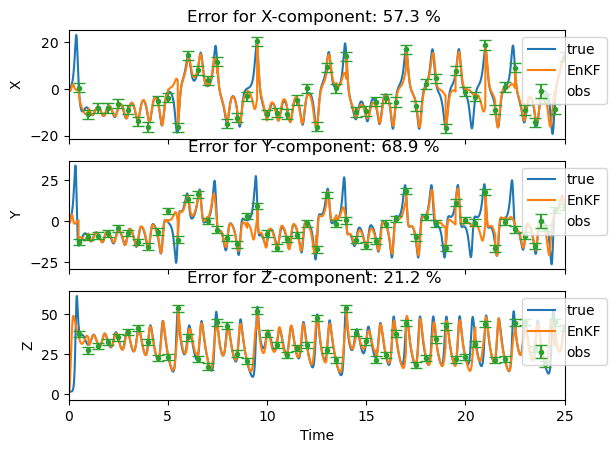

In [13]:
# Plot results
plot_ensemble = False  # Change to True if you want to visualize ensemble members
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)
iobs = 0
for k, comp in enumerate(["X", "Y", "Z"]):
    ax[k].plot(time.cpu(), xt.cpu()[k, :], label='true')
    ax[k].plot(time.cpu(), xEnKF.cpu()[k, :], label='EnKF')
    # if plot_ensemble:
    #     for e in range(Ne):
    #         ax[k].plot(time.cpu(), x_ens.cpu()[k, :, e], c='k', lw=0.1, zorder=-4)
    if WhichVariablesAreObserved[k] > 0:
        ax[k].errorbar(time_obs.cpu(), y.cpu()[iobs, :], yerr=sqrt_s.cpu()[iobs, iobs],
                       fmt='o', markersize=3, capsize=4, label='obs')
        iobs = iobs + 1
    ax[k].legend(bbox_to_anchor=(0.9, 1), loc='upper left', frameon=True)
    ax[k].set_ylabel(comp)
    ax[k].title.set_text(
        f"Error for {comp}-component: %4.1f %% "
        % (100.0 * cum_error_comp[k] / norm_comp[k])
    )
ax[-1].set_xlabel('Time')
ax[-1].set_xlim(time.cpu()[0], time.cpu()[-1])
plt.show()